In [1]:
import numpy as np
import pandas as pd
from joblib import delayed, Parallel

In [2]:
class paths:
    TRAIN = './data/train.csv'
    TEST = './data/test.csv'

In [3]:
df = pd.read_csv(paths.TRAIN)

In [62]:
def feature_engineering(df):
    new_df = df.copy()
    new_df['Abs_Orientation'] = np.abs(new_df['Orientation_Index'])
    new_df['New_Lum'] = 1 + new_df['Luminosity_Index']
    new_df['Width'] = np.abs(new_df['X_Maximum'] - new_df['X_Minimum'])
    new_df['Height'] = np.abs(new_df['Y_Maximum'] - new_df['Y_Minimum'])
    new_df['Lum_Range'] = np.abs(
        new_df['Maximum_of_Luminosity'] - new_df['Minimum_of_Luminosity'])
    new_df['Feature1'] = new_df['Sum_of_Luminosity'] / new_df['New_Lum']
    new_df['Feature2'] = new_df['Steel_Plate_Thickness'] * \
        new_df['Length_of_Conveyer']

    new_df['Edges_YX'] = new_df['Edges_Y_Index'] * new_df['Edges_X_Index']
    new_df['Edges_Y/X'] = new_df['Edges_Y_Index'] / new_df['Edges_X_Index']
    new_df['Log_YX'] = new_df['Log_Y_Index'] * new_df['Log_X_Index']
    new_df['Log_Y/X'] = new_df['Log_Y_Index'] / new_df['Log_X_Index']

    drop_cols = ['Y_Maximum', 'Y_Minimum', 'X_Maximum', 'X_Minimum',
                 'SigmoidOfAreas', 'Pixels_Areas', 'Outside_X_Index',
                 'X_Perimeter', 'Y_Perimeter', 'Square_Index',
                 'Orientation_Index', 'Luminosity_Index', 'Height']

    new_df = new_df.drop(drop_cols, axis=1)
    return new_df

In [63]:
train_df = feature_engineering(df)
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,19219.0,9609.000000,5548.191747,0.000000,4804.500000,9609.000000,14413.500000,1.921800e+04
Sum_of_Luminosity,19219.0,191846.678235,442024.694057,250.000000,9848.000000,18238.000000,67978.000000,1.159141e+07
Minimum_of_Luminosity,19219.0,84.808419,28.800344,0.000000,70.000000,90.000000,105.000000,1.960000e+02
Maximum_of_Luminosity,19219.0,128.647380,14.196976,39.000000,124.000000,127.000000,135.000000,2.530000e+02
Length_of_Conveyer,19219.0,1459.350747,145.568687,1227.000000,1358.000000,1364.000000,1652.000000,1.794000e+03
TypeOfSteel_A300,19219.0,0.402674,0.490449,0.000000,0.000000,0.000000,1.000000,1.000000e+00
TypeOfSteel_A400,19219.0,0.596337,0.490644,0.000000,0.000000,1.000000,1.000000,1.000000e+00
Steel_Plate_Thickness,19219.0,76.213122,53.931960,40.000000,40.000000,69.000000,80.000000,3.000000e+02
Edges_Index,19219.0,0.352939,0.318976,0.000000,0.058600,0.238500,0.656100,9.952000e-01
Empty_Index,19219.0,0.409309,0.124143,0.000000,0.317500,0.413500,0.494600,9.275000e-01


In [64]:
y_cols = ['Pastry', 'Z_Scratch', 'K_Scatch',
          'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
y = train_df[y_cols]
X = train_df.drop(y, axis=1)
ids = X['id']
X = X.drop(['id'], axis=1)

In [65]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5)

trains = []
valids = []
for fold, (train_index, valid_index) in enumerate(gkf.split(X, y, ids)):
    print(f'Fold: {fold}')
    train_X = X.loc[train_index]
    train_y = y.loc[train_index]
    valid_X = X.loc[valid_index]
    valid_y = y.loc[valid_index]
    trains.append((train_X, train_y))
    valids.append((valid_X, valid_y))

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [66]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

estimators = 1000
stopping = 5
lr = 0.05

xgboosts = []
aucs = np.zeros(7)

for fold in range(5):
    print(f'Fold: {fold}')

    # Fit Model
    model = XGBClassifier(n_estimators=estimators,
                          early_stopping_rounds=stopping,
                          learning_rate=lr,
                          n_jobs=4)
    model.fit(*trains[fold], 
              eval_set=[valids[fold]], verbose=0)
    xgboosts.append(model)

    # Calculate ROCS
    X_val, y_val = valids[fold]
    preds = model.predict_proba(X_val)
    aucs += np.array(roc_auc_score(y_val, preds, multi_class='ovr', average=None))
    
val_aucs = pd.Series(aucs, index=y_cols)/5
display(val_aucs)
print(f'Mean AUC: {round(val_aucs.mean(), 4)}')

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Pastry          0.866755
Z_Scratch       0.955228
K_Scatch        0.985001
Stains          0.991228
Dirtiness       0.879002
Bumps           0.806511
Other_Faults    0.701914
dtype: float64

Mean AUC: 0.8837


In [67]:
importances = xgboosts[0].feature_importances_
for xgboost in xgboosts[1:]:
    importances += xgboost.feature_importances_
importances = np.array(importances) / 5
Xcols = np.array(X.columns)[np.argsort(importances)][::-1]
sortd = np.sort(importances)[::-1]
for i, col in enumerate(Xcols):
    print(f'{col}: {round(sortd[i], 2)}')

Width: 0.20000000298023224
LogOfAreas: 0.11999999731779099
Log_X_Index: 0.10000000149011612
TypeOfSteel_A300: 0.09000000357627869
Steel_Plate_Thickness: 0.05000000074505806
Feature2: 0.05000000074505806
Log_Y/X: 0.03999999910593033
Length_of_Conveyer: 0.03999999910593033
Outside_Global_Index: 0.029999999329447746
TypeOfSteel_A400: 0.029999999329447746
Edges_Y_Index: 0.029999999329447746
Log_Y_Index: 0.019999999552965164
Minimum_of_Luminosity: 0.019999999552965164
Lum_Range: 0.019999999552965164
Abs_Orientation: 0.019999999552965164
Log_YX: 0.019999999552965164
Edges_Index: 0.019999999552965164
Sum_of_Luminosity: 0.009999999776482582
Maximum_of_Luminosity: 0.009999999776482582
Feature1: 0.009999999776482582
New_Lum: 0.009999999776482582
Edges_YX: 0.009999999776482582
Empty_Index: 0.009999999776482582
Edges_X_Index: 0.009999999776482582
Edges_Y/X: 0.009999999776482582


# Class-Based Importances

In [68]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

estimators = 1000
stopping = 10
lr = 0.05

aucs = pd.Series()

for i, col in enumerate(y_cols):
    print('='*30)
    print(col)
    print('='*30)
    xgboosts=[]
    aucs_sum = 0
    for fold in range(5):
        
        X, y = trains[fold]
        y_col = np.array(y[col])
        X_val, y_val = valids[fold]
        y_val_col = np.array(y_val[col])

        # Fit Model

        model = XGBClassifier(n_estimators=estimators,
                              early_stopping_rounds=stopping,
                              learning_rate=lr,
                              n_jobs=4,
                              eval_metric='auc')

        model.fit(X, y_col, eval_set=
                  [(X_val, np.array(y_val[col]))], verbose=0)
        xgboosts.append(model)

        # Calculate ROCS
        preds = model.predict_proba(X_val)[:,1]
        aucs_sum += roc_auc_score(np.array(y_val[col]), preds)

    aucs[col] = aucs_sum / 5
    # Importances
    importances = xgboosts[0].feature_importances_
    for xgboost in xgboosts[1:]:
        importances += xgboost.feature_importances_
    importances = np.array(importances) / 5
    Xcols = np.array(X.columns)[np.argsort(importances)][::-1]
    sortd = np.sort(importances)[::-1]
    for i, clm in enumerate(Xcols):
        print(f'{clm}: {round(sortd[i], 2)}')

display(aucs)
print(f'Mean AUC: {round(aucs.mean(), 4)}')

Pastry
Log_Y/X: 0.23999999463558197
Edges_Y_Index: 0.11999999731779099
Outside_Global_Index: 0.10999999940395355
TypeOfSteel_A300: 0.03999999910593033
Length_of_Conveyer: 0.03999999910593033
Minimum_of_Luminosity: 0.029999999329447746
Abs_Orientation: 0.029999999329447746
Lum_Range: 0.029999999329447746
Steel_Plate_Thickness: 0.029999999329447746
Feature1: 0.019999999552965164
Log_Y_Index: 0.019999999552965164
Empty_Index: 0.019999999552965164
Sum_of_Luminosity: 0.019999999552965164
TypeOfSteel_A400: 0.019999999552965164
Feature2: 0.019999999552965164
Width: 0.019999999552965164
Edges_Index: 0.019999999552965164
LogOfAreas: 0.019999999552965164
New_Lum: 0.019999999552965164
Log_X_Index: 0.019999999552965164
Maximum_of_Luminosity: 0.019999999552965164
Log_YX: 0.019999999552965164
Edges_X_Index: 0.019999999552965164
Edges_Y/X: 0.019999999552965164
Edges_YX: 0.009999999776482582
Z_Scratch
TypeOfSteel_A300: 0.4000000059604645
Length_of_Conveyer: 0.17000000178813934
Steel_Plate_Thickness: 0

Pastry          0.866608
Z_Scratch       0.955475
K_Scatch        0.984801
Stains          0.985495
Dirtiness       0.876888
Bumps           0.805847
Other_Faults    0.704557
dtype: float64

Mean AUC: 0.8828


## Bump Feature Engineering

In [ ]:
bumps = train_df.loc[train_df['Bumps']==1].drop(y_cols, axis=1)
bumps_A300 = bumps.loc[bumps['TypeOfSteel_A300']==1].drop(['TypeOfSteel_A300','TypeOfSteel_A400'], axis=1)
bumps_A400 = bumps.loc[bumps['TypeOfSteel_A400'] == 1].drop(['TypeOfSteel_A300','TypeOfSteel_A400'], axis=1)

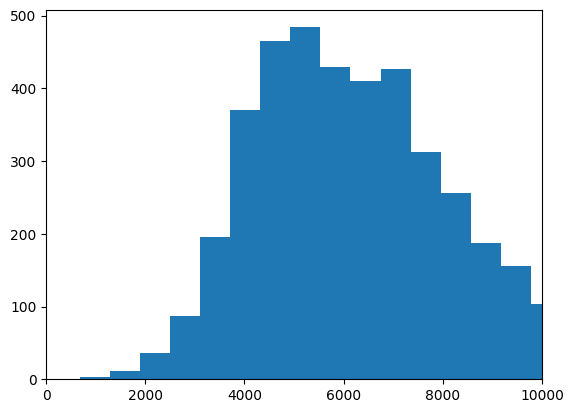

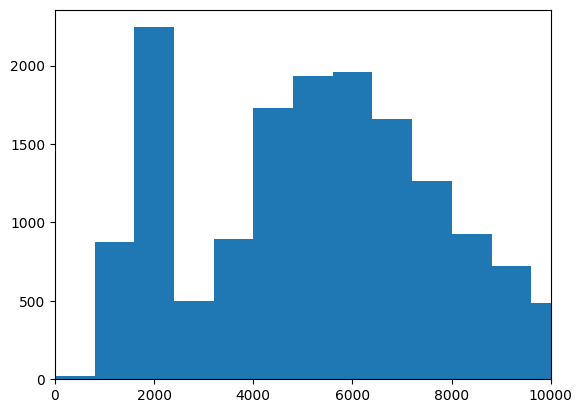

In [ ]:
import matplotlib.pyplot as plt
plt.hist(bumps['Sine_MinLum'] * bumps['Steel_Plate_Thickness'], bins=100)
plt.xlim(0, 10000)
plt.show()
plt.hist(train_df['Sine_MinLum'] * train_df['Steel_Plate_Thickness'], bins=100)
plt.xlim(0, 10000)
plt.show()

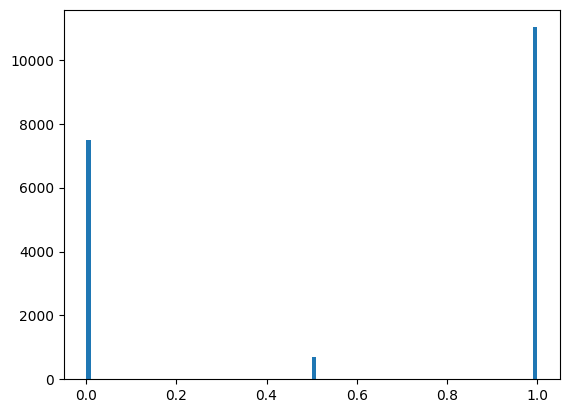

In [ ]:
plt.hist(train_df['Outside_Global_Index'], bins=100)
plt.show()